# Assignment 2: Linear regression {-}

This assignment aims at familiarizing you with the use of Linear Regression model supported by scikit-learn. You will have to:

- Analyze the data.
- Pre-process the data.
- Split train/test sets.
- Train a Linear Regression model using the training set, then make prediction on the test set.
- Evaluate the model performance on the test set.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment2-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named DataViz-\<StudentID>-Assignment2 (e.g., DataViz-2012345-Assigment2) and then compressed with the same name.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

This is a dataset about loan amount for which a customer can request a bank with his/her collateral house.

* Gender: Gender of customer requesting for a loan ('F' or 'M').
* Age: Age of customer requesting for a loan (non-negative values).
* Income (USD): Income of customer requesting for a loan (non-negative values).
* Income Stability: Income stability of customer requesting for a loan ("Low" or "High").
* Property Age: Age of the property (non-negative number of days).
* Property Location: Location of the property ("Rural", "Urban", and "Semi-Urban").
* Property Price: Price of the property (USD).
* Loan Sanction Amount (USD): Ammount of loan the customer can requst for (USD, target value).

In [3]:
# Load and display data
data = pd.read_csv("house_loan.csv")
data.head()

,Gender,Age,Income (USD),Income Stability,Property Age,Property Location,Property Price,Loan Sanction Amount (USD)
0,F,19,1641.25,Low,1651.25,Rural,59641.82,21026.420753
1,M,29,1989.71,Low,1990.71,Urban,179858.51,60595.183366
2,F,37,1849.91,Low,1856.91,Rural,117297.62,39181.648002
3,M,65,2735.18,High,2747.18,Rural,354417.72,128497.710865
4,F,62,4741.78,High,4740.78,Urban,82049.80,39386.919336


In [4]:
X = data.drop('Loan Sanction Amount (USD)', axis=1)
y = data['Loan Sanction Amount (USD)']

### Analyze

In [5]:
data.shape

(47297, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47297 entries, 0 to 47296
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      47297 non-null  object 
 1   Age                         47297 non-null  int64  
 2   Income (USD)                47265 non-null  float64
 3   Income Stability            47285 non-null  object 
 4   Property Age                47263 non-null  float64
 5   Property Location           47294 non-null  object 
 6   Property Price              47297 non-null  float64
 7   Loan Sanction Amount (USD)  47297 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 2.9+ MB


* There are 47297 rows (samples) and 8 columns (7 independent variables and 1 dependent variables)
* `Income` has 47275 non-null values, `Income stability` has 47285 non-null values, `Property Age` has 47263 non-null values, `Property Location` has 47294 non-null values. 
* There are 3 categorical variables: Gender, Income Stability, Property Location. There are five number variables, which are int64 and float 64.


In [7]:
# numerical attriutes
numberical_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
numberical_features.remove('Loan Sanction Amount (USD)') # because it is independet variable, so we don't need it here
numberical_features

['Age', 'Income (USD)', 'Property Age', 'Property Price']

In [8]:
# categorical attributes
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Gender', 'Income Stability', 'Property Location']

#### Numerical variables

In [9]:
data.describe()

,Age,Income (USD),Property Age,Property Price,Loan Sanction Amount (USD)
count,47297.000000,47265.000000,47263.000000,4.729700e+04,47297.000000
mean,40.000063,2586.684384,2586.611058,1.350880e+05,46487.229765
std,16.086128,1558.768809,1558.842286,9.457875e+04,32549.905634
min,18.000000,372.700000,370.700000,7.859620e+03,254.586578
25%,24.000000,1653.740000,1652.820000,6.250408e+04,21782.822159
50%,40.000000,2245.480000,2244.810000,1.130936e+05,38822.132402
75%,55.000000,3128.560000,3128.380000,1.819546e+05,62612.236905
max,65.000000,54662.750000,54647.750000,1.077967e+06,366131.165218


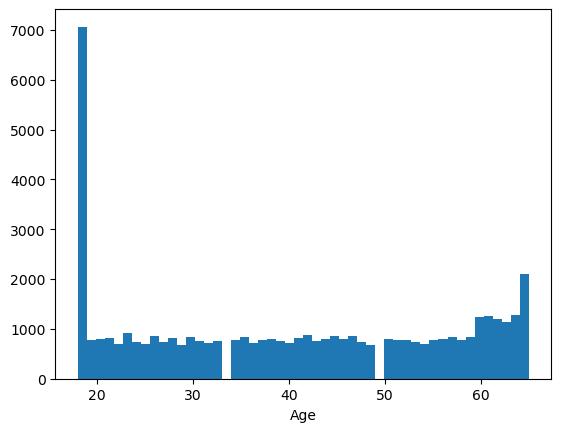

In [10]:
# Age distribution
plt.hist(data['Age'], bins=50)
plt.xlabel('Age')
plt.show()

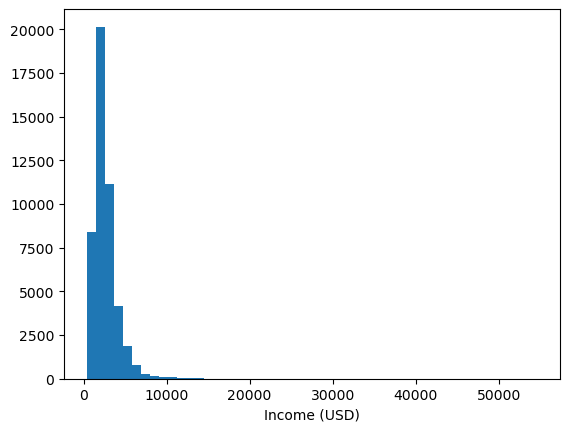

In [11]:
# Income distribution
plt.hist(data['Income (USD)'], bins=50)
plt.xlabel('Income (USD)')
plt.show()

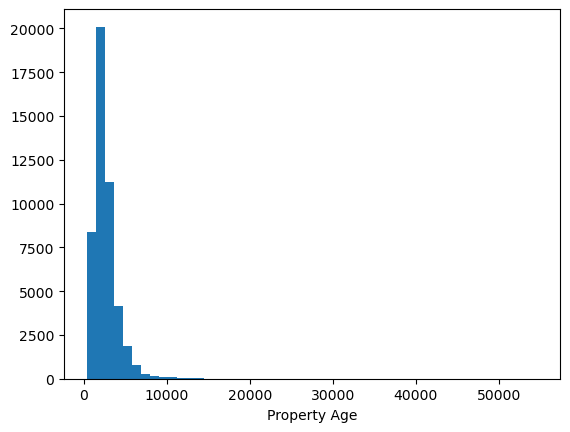

In [12]:
# Property Age distribution
plt.hist(data['Property Age'], bins=50)
plt.xlabel('Property Age')
plt.show()

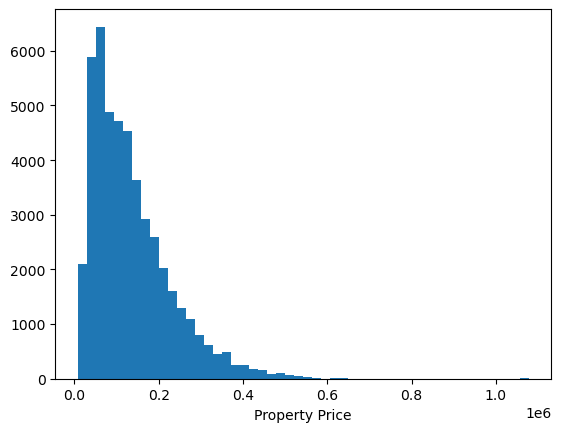

In [13]:
# Property Price distribution
plt.hist(data['Property Price'], bins=50)
plt.xlabel('Property Price')
plt.show()

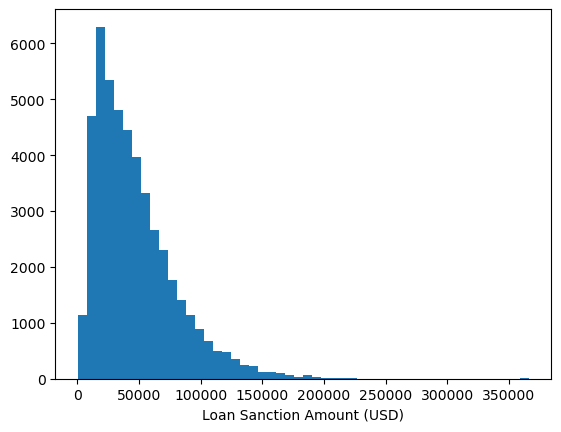

In [14]:
# Loan Amount distribution
plt.hist(data['Loan Sanction Amount (USD)'], bins=50)
plt.xlabel('Loan Sanction Amount (USD)')
plt.show()

<Axes: >

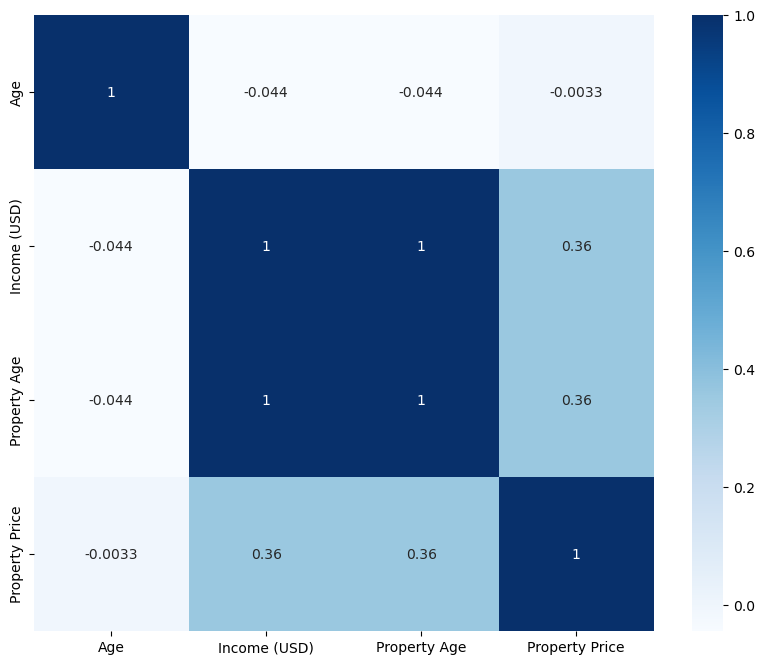

In [15]:
# Correlation matrix 
corr = data[numberical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap=plt.cm.Blues)

There a strong correlation between `Property Age` and `Income (USD)`

#### Categorical variables

In [16]:
data['Gender'].value_counts()

Gender
F    23669
M    23628
Name: count, dtype: int64

In [17]:
data['Income Stability'].value_counts()

Income Stability
Low     43078
High     4207
Name: count, dtype: int64

In [18]:
data['Property Location'].value_counts()

Property Location
Semi-Urban    16371
Rural         15959
Urban         14964
Name: count, dtype: int64

### Pre-processing data

There are 4 variables that have missing values, which are `Income`, `Income stability`, `Property Age`, `Property Location` so we need to fill NA values by using `SimpleImputer` from library `scikit-learn`

In [19]:
# Check the null values 
data.isnull().sum()

Gender                         0
Age                            0
Income (USD)                  32
Income Stability              12
Property Age                  34
Property Location              3
Property Price                 0
Loan Sanction Amount (USD)     0
dtype: int64

In [20]:
# remove duplicates 
data.drop_duplicates(inplace=True)

In [21]:
# Fill missing values & Handle categorical features
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_handle = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Fill missing values with median
    ('std_scaler', StandardScaler())   # Standardize features by removing the mean and scaling to unit variance
])

cat_hanlde = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing values with most frequent
    ('onehot', OneHotEncoder(sparse=False))# Encode categorical features as a one-hot numeric array
])

# Combine numerical and categorical features handling pipelines
preprocess = ColumnTransformer([
    ('num', num_handle, numberical_features),
    ('cat', cat_hanlde, categorical_features)
])

In [22]:
X = preprocess.fit_transform(X)

/Users/huynguyen/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Split Train-Test data

In [23]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=17)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37837, 11), (9460, 11), (37837,), (9460,))

### Train a Linear Regression model using the training set, then make prediction on the test set.

In [24]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [25]:
print("Model intercept: " + str(model.intercept_))   
print("Model coefficients: " + str(model.coef_)) 

Model intercept: 51066.941346912085
Model coefficients: [-1.27609923e+03  2.90342911e+04 -2.74393238e+04  3.18060313e+04
  1.25674936e+02 -1.25674936e+02  5.56457657e+03 -5.56457657e+03
  1.37511156e+02 -1.39994547e+02  2.48339048e+00]


### Evaluate the model performance on the test set.

In [26]:
model.predict(X_test)

array([78336.32197461, 63822.13103808, 74364.15527758, ...,
       45537.86447277, 98121.39244305, 11139.10860355])

In [27]:
# R-square score
model.score(X_test, y_test)

0.9985256248653275

In [28]:
# evaluation by RMSE 
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: " + str(rmse))

RMSE: 1225.9019577588142
